In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from CDAE import AutoEncoder
from tqdm import trange
from utils import *
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data preprocessing

In [2]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def get_matrix(data):
    matrix = np.zeros((total_usr, total_item), dtype=np.float32)
    for line in data:
        uid = user_map[line[0]]
        iid = item_map[line[1]]
        matrix[uid, iid] = 1
    
    return matrix

In [3]:
userList = np.load('../data/netflix/netflix_userList.npy')
itemList = np.load('../data/netflix/netflix_itemList.npy')

total_usr = len(userList)
total_item = len(itemList)

user_map = get_map(userList)
item_map = get_map(itemList)

In [4]:
train_rating_all = np.load('../data/netflix/train_rating_all.npy')

In [5]:
import pickle

train_indices_all = None
test_indices_all = None

with open('../data/netflix/train_indices_all.pkl', 'rb') as train_indice_file:
    train_indices_all = pickle.load(train_indice_file)
    train_indice_file.close()
    
with open('../data/netflix/test_indices_all.pkl', 'rb') as test_indice_file:
    test_indices_all = pickle.load(test_indice_file)
    test_indice_file.close()

df = pd.read_csv('../data/class/rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5
df_array = df.as_matrix()

userList = sorted(df['uid'].unique())
itemList = sorted(df['iid'].unique())

total_usr = len(df['uid'].unique())
total_item = len(df['iid'].unique())

user_map = get_map(userList)
item_map = get_map(itemList)
    

sparsity = len(df)/(total_usr*total_item)
print("sparsity of ratings is %.2f%%" %(sparsity*100))
print ("num. of users: %d, num. of items: %d, num. of ratings: %d" % (total_usr, total_item, len(df)))

# Clustering

In [15]:
user_vectors = np.load('../data/netflix/user_vectors.npy')
pca = PCA(n_components=2, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
colors = np.random.rand(len(pca_out[:, 0]))


plt.scatter(pca_out[:, 0], pca_out[:, 1], c=colors, alpha=0.5)
plt.savefig('figs/user_vecPCA_scatter.jpg')
plt.gcf().clear()

In [28]:
user_vectors = np.load('../data/netflix/user_vectors.npy')
pca = PCA(n_components=10, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
NUM_CLUSTER = 50
kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=50, algorithm='elkan')


kmeans.fit(pca_out)

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
label_map = {}
for i in kmeans.labels_:
    if i not in label_map:
        label_map[i] = 1
    else:
        label_map[i] += 1

print (label_map)

{9: 5228, 40: 4973, 3: 5129, 25: 5166, 32: 5128, 22: 5072, 1: 5140, 11: 5174, 38: 5156, 48: 5214, 5: 5357, 2: 5135, 47: 5247, 37: 5333, 24: 5403, 7: 4987, 46: 5197, 34: 5138, 36: 5054, 43: 5211, 42: 5152, 12: 4991, 21: 5135, 18: 5187, 26: 5219, 31: 5574, 0: 5117, 35: 5057, 28: 5106, 16: 4909, 15: 5229, 33: 5179, 49: 5249, 29: 4953, 30: 5097, 20: 4966, 6: 5116, 14: 4925, 39: 5043, 8: 4969, 19: 5434, 17: 5324, 23: 5053, 10: 5324, 44: 5014, 41: 5136, 13: 5005, 45: 4857, 27: 4998, 4: 4923}


In [30]:
label_index = {}
for i in range(NUM_CLUSTER):
    label_index[i] = []
    
label_list = list(kmeans.labels_)

for idx, i in enumerate(label_list):
    label_index[i].append(idx)

rating = np.zeros((total_usr, total_item), dtype=np.int8)
for line in df_array:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    rating[uid, iid] = 1

In [31]:
test_aps_5 = []
test_aps_10 = []
test_rec_5 = []
test_rec_10 = []

for i in range(NUM_CLUSTER):
    print ("Cluster %d." % (i))
    train_rating = np.take(train_rating_all, label_index[i], axis=0)
    train_user = label_index[i]
    # train_rating, train_indices, test_indices = gen_train_test(rating_n)
    # train_rating = np.take(rating, label_index[i], axis=0)
    train_indices = np.take(train_indices_all, label_index[i])
    test_indices = np.take(test_indices_all, label_index[i])
    
    tf.reset_default_graph()

    autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                              batch_size=64, epochs=200)
    autoencoder.model_load(0)
    autoencoder.train(rating=train_rating,
                      train_idents=train_user,
                      train_indices=train_indices,
                      test_indices=test_indices)
    
    """autoencoder.train(rating=rating,
                     train_idents=train_user)"""
    
    test_ap_5 = autoencoder.log['ap@5']
    test_ap_10 = autoencoder.log['ap@10']
    recs_5 = autoencoder.log['recall@5']
    recs_10 = autoencoder.log['recall@10']
    train_loss = autoencoder.log['train_loss']
    
    # top_N_ap = sorted(test_ap,reverse=True)[:20]
    # test_aps.append(np.mean(top_N_ap))
    
    test_aps_5.append(max(test_ap_5))
    test_aps_10.append(max(test_ap_10))
    test_rec_5.append(max(recs_5))
    test_rec_10.append(max(recs_10))
    
    plt.plot(range(len(test_ap_10)), test_ap_10, color='green', label='Test AP')
    # plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
    plt.legend(loc="upper right")
    plt.title("Train 200 epoch")
    plt.xlabel('#Epoch')
    plt.ylabel('AP_10')
    plt.savefig('./figs/test_ap_cluster_%d.jpg' % (i))
    plt.gcf().clear()
    
    plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train Loss')
    # plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
    plt.legend(loc="upper right")
    plt.title("Train 500 epoch")
    plt.xlabel('#Epoch')
    plt.ylabel('Loss')
    plt.savefig('./figs/train_loss_cluster_%d.jpg' % (i))
    plt.gcf().clear()
    

Cluster 0.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:03<00:00,  2.68it/s]


Cluster 1.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:55<00:00,  2.65it/s]


Cluster 2.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:54<00:00,  2.66it/s]


Cluster 3.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:57<00:00,  2.66it/s]


Cluster 4.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:54<00:00,  2.77it/s]


Cluster 5.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:05<00:00,  2.55it/s]


Cluster 6.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:53<00:00,  2.67it/s]


Cluster 7.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:58<00:00,  2.75it/s]


Cluster 8.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:49<00:00,  2.75it/s]


Cluster 9.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:06<00:00,  2.61it/s]


Cluster 10.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:07<00:00,  2.57it/s]


Cluster 11.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.65it/s]


Cluster 12.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:55<00:00,  2.73it/s]


Cluster 13.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.72it/s]


Cluster 14.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:44<00:00,  2.78it/s]


Cluster 15.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:01<00:00,  2.61it/s]


Cluster 16.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:45<00:00,  2.79it/s]


Cluster 17.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:03<00:00,  2.56it/s]


Cluster 18.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:03<00:00,  2.61it/s]


Cluster 19.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:14<00:00,  2.53it/s]


Cluster 20.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:51<00:00,  2.71it/s]


Cluster 21.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:01<00:00,  2.66it/s]


Cluster 22.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:55<00:00,  2.68it/s]


Cluster 23.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.70it/s]


Cluster 24.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:11<00:00,  2.53it/s]


Cluster 25.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:06<00:00,  2.65it/s]


Cluster 26.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:08<00:00,  2.63it/s]


Cluster 27.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:49<00:00,  2.73it/s]


Cluster 28.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:04<00:00,  2.66it/s]


Cluster 29.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:57<00:00,  2.75it/s]


Cluster 30.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:56<00:00,  2.68it/s]


Cluster 31.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:23<00:00,  2.45it/s]


Cluster 32.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:01<00:00,  2.66it/s]


Cluster 33.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.64it/s]


Cluster 34.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.66it/s]


Cluster 35.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:53<00:00,  2.69it/s]


Cluster 36.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:54<00:00,  2.71it/s]


Cluster 37.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:05<00:00,  2.56it/s]


Cluster 38.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:02<00:00,  2.65it/s]


Cluster 39.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:43<00:00,  2.73it/s]


Cluster 40.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:58<00:00,  2.75it/s]


Cluster 41.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:57<00:00,  2.67it/s]


Cluster 42.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:48<00:00,  2.65it/s]


Cluster 43.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:57<00:00,  2.61it/s]


Cluster 44.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:54<00:00,  2.73it/s]


Cluster 45.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [03:40<00:00,  2.81it/s]


Cluster 46.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:03<00:00,  2.62it/s]


Cluster 47.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:08<00:00,  2.60it/s]


Cluster 48.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:07<00:00,  2.62it/s]


Cluster 49.
INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


100%|██████████| 200/200 [04:04<00:00,  2.57it/s]


In [32]:
ap_5 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap_5 += test_aps_5[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps_5[i], num, test_aps_5[i]*num))
    
ap_5 = ap_5 / (total_usr)

print ("Over all average ap: %f" % (ap_5))

Cluster 0, aps: 0.158188, num: 5117, weighted ap: 809.448332
Cluster 1, aps: 0.137365, num: 5140, weighted ap: 706.057263
Cluster 2, aps: 0.136240, num: 5135, weighted ap: 699.592462
Cluster 3, aps: 0.142868, num: 5129, weighted ap: 732.771136
Cluster 4, aps: 0.157882, num: 4923, weighted ap: 777.253245
Cluster 5, aps: 0.136853, num: 5357, weighted ap: 733.123268
Cluster 6, aps: 0.132288, num: 5116, weighted ap: 676.783516
Cluster 7, aps: 0.156449, num: 4987, weighted ap: 780.212048
Cluster 8, aps: 0.142600, num: 4969, weighted ap: 708.578740
Cluster 9, aps: 0.149470, num: 5228, weighted ap: 781.430293
Cluster 10, aps: 0.145626, num: 5324, weighted ap: 775.315203
Cluster 11, aps: 0.149073, num: 5174, weighted ap: 771.301620
Cluster 12, aps: 0.149169, num: 4991, weighted ap: 744.503794
Cluster 13, aps: 0.163814, num: 5005, weighted ap: 819.890091
Cluster 14, aps: 0.133772, num: 4925, weighted ap: 658.825297
Cluster 15, aps: 0.140143, num: 5229, weighted ap: 732.807211
Cluster 16, aps: 0

In [33]:
ap_10 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    ap_10 += test_aps_10[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_aps_10[i], num, test_aps_10[i]*num))
    
ap_10 = ap_10 / (total_usr)

print ("Over all average ap: %f" % (ap_10))

Cluster 0, aps: 0.119008, num: 5117, weighted ap: 608.965040
Cluster 1, aps: 0.101743, num: 5140, weighted ap: 522.958865
Cluster 2, aps: 0.100316, num: 5135, weighted ap: 515.121336
Cluster 3, aps: 0.107061, num: 5129, weighted ap: 549.116244
Cluster 4, aps: 0.117617, num: 4923, weighted ap: 579.027734
Cluster 5, aps: 0.099945, num: 5357, weighted ap: 535.407748
Cluster 6, aps: 0.097201, num: 5116, weighted ap: 497.280561
Cluster 7, aps: 0.116240, num: 4987, weighted ap: 579.686391
Cluster 8, aps: 0.105860, num: 4969, weighted ap: 526.020069
Cluster 9, aps: 0.108676, num: 5228, weighted ap: 568.157687
Cluster 10, aps: 0.109352, num: 5324, weighted ap: 582.188159
Cluster 11, aps: 0.111508, num: 5174, weighted ap: 576.944110
Cluster 12, aps: 0.108920, num: 4991, weighted ap: 543.620213
Cluster 13, aps: 0.122930, num: 5005, weighted ap: 615.265712
Cluster 14, aps: 0.098964, num: 4925, weighted ap: 487.398146
Cluster 15, aps: 0.102995, num: 5229, weighted ap: 538.559729
Cluster 16, aps: 0

In [34]:
recall_5 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    recall_5 += test_rec_5[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_rec_5[i], num, test_rec_5[i]*num))
    
recall_5 = recall_5 / (total_usr)

print ("Over all average ap: %f" % (recall_5))

Cluster 0, aps: 0.237175, num: 5117, weighted ap: 1213.626179
Cluster 1, aps: 0.206389, num: 5140, weighted ap: 1060.838889
Cluster 2, aps: 0.206854, num: 5135, weighted ap: 1062.197467
Cluster 3, aps: 0.214789, num: 5129, weighted ap: 1101.653266
Cluster 4, aps: 0.234416, num: 4923, weighted ap: 1154.031308
Cluster 5, aps: 0.207086, num: 5357, weighted ap: 1109.358703
Cluster 6, aps: 0.201146, num: 5116, weighted ap: 1029.062083
Cluster 7, aps: 0.231050, num: 4987, weighted ap: 1152.244752
Cluster 8, aps: 0.212417, num: 4969, weighted ap: 1055.499776
Cluster 9, aps: 0.222072, num: 5228, weighted ap: 1160.994914
Cluster 10, aps: 0.215600, num: 5324, weighted ap: 1147.855456
Cluster 11, aps: 0.220745, num: 5174, weighted ap: 1142.133293
Cluster 12, aps: 0.223434, num: 4991, weighted ap: 1115.157519
Cluster 13, aps: 0.242323, num: 5005, weighted ap: 1212.826147
Cluster 14, aps: 0.201189, num: 4925, weighted ap: 990.855450
Cluster 15, aps: 0.211525, num: 5229, weighted ap: 1106.065465
Clu

In [35]:
recall_10 = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    recall_10 += test_rec_10[i] * num
    print ("Cluster %d, aps: %f, num: %d, weighted ap: %f" % (i, test_rec_10[i], num, test_rec_10[i]*num))
    
recall_10 = recall_10 / (total_usr)

print ("Over all average ap: %f" % (recall_10))

Cluster 0, aps: 0.206464, num: 5117, weighted ap: 1056.475690
Cluster 1, aps: 0.180764, num: 5140, weighted ap: 929.126389
Cluster 2, aps: 0.178489, num: 5135, weighted ap: 916.540709
Cluster 3, aps: 0.188782, num: 5129, weighted ap: 968.261450
Cluster 4, aps: 0.203605, num: 4923, weighted ap: 1002.349769
Cluster 5, aps: 0.178364, num: 5357, weighted ap: 955.497744
Cluster 6, aps: 0.175587, num: 5116, weighted ap: 898.304318
Cluster 7, aps: 0.201313, num: 4987, weighted ap: 1003.949366
Cluster 8, aps: 0.185447, num: 4969, weighted ap: 921.485939
Cluster 9, aps: 0.188995, num: 5228, weighted ap: 988.065556
Cluster 10, aps: 0.190166, num: 5324, weighted ap: 1012.444692
Cluster 11, aps: 0.192919, num: 5174, weighted ap: 998.163402
Cluster 12, aps: 0.191075, num: 4991, weighted ap: 953.656544
Cluster 13, aps: 0.210828, num: 5005, weighted ap: 1055.193928
Cluster 14, aps: 0.178243, num: 4925, weighted ap: 877.845600
Cluster 15, aps: 0.182643, num: 5229, weighted ap: 955.038678
Cluster 16, a

# Old

### For netflix huge dataset

user_train_rating = np.load('../data/netflix/rating_matrix_CDAE.npy')

train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

import pickle

np.save('../data/netflix/train_rating_all.npy', train_rating_all)

with open('../data/netflix/train_indices_all.pkl', 'wb') as train_indice_file:
    pickle.dump(train_indices_all, train_indice_file)
    
with open('../data/netflix/test_indices_all.pkl', 'wb') as test_indice_file:
    pickle.dump(test_indices_all, test_indice_file)

### For others

train_data = df.as_matrix()

user_train_rating = np.zeros((total_usr, total_item), dtype=np.int32)

for line in train_data:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    user_train_rating[uid, iid] = 1

## Build Model and Training

In [6]:
# train_rating_all, train_indices_all, test_indices_all = gen_train_test(user_train_rating)

tf.reset_default_graph()

train_user_all = np.nonzero(np.count_nonzero(train_rating_all, axis=1))[0]

autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                          batch_size=100, epochs=200)


autoencoder.train(rating=train_rating_all,
                  train_idents=train_user_all,
                  train_indices=train_indices_all,
                  test_indices=test_indices_all)

autoencoder.model_save(0)

100%|██████████| 200/200 [3:16:52<00:00, 18.85s/it]   


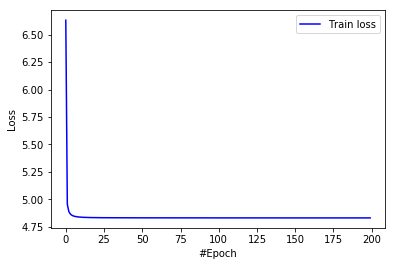

In [7]:
train_loss = autoencoder.log['train_loss']

plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
test_ap = autoencoder.log['ap@5']

top_N_ap = sorted(test_ap,reverse=True)[:20]

plt.plot(range(5, (len(test_ap)+1)*5, 5), test_ap, color='green', label='Test AP')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('AP')
plt.show()

# print (np.mean(top_N_ap))

print (max(test_ap))

0.14626234599480878


In [10]:
test_recall = autoencoder.log['recall@5']

plt.plot(range(20, (len(test_recall)+1)*20, 20), test_recall, color='green', label='Test Recall')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('Recall')
plt.show()

# print (np.mean(top_N_ap))

print (max(test_recall))

0.2182329943067956


In [11]:
test_recall = autoencoder.log['recall@10']

plt.plot(range(20, (len(test_recall)+1)*20, 20), test_recall, color='green', label='Test Recall')
# plt.plot(range(len(test_loss)), test_loss, color='red', label='Test loss')
plt.legend(loc="upper right")
plt.title("Train 200 epoch")
plt.xlabel('#Epoch')
plt.ylabel('Recall')
plt.show()

# print (np.mean(top_N_ap))

print (max(test_recall))

0.189307390841121


In [24]:
tf.reset_default_graph()
autoencoder = AutoEncoder(user_num=total_usr, item_num=total_item, mode='user', loss_function='cross_entropy',
                          batch_size=100, epochs=1000)
autoencoder.model_load(0)

INFO:tensorflow:Restoring parameters from model/cdae_0.ckpt


In [25]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)
u_vectors = np.load('../data/netflix/user_vectors.npy')

In [26]:
feature_vectors = np.zeros((total_usr, 20), dtype=np.float32)
for i in range(total_usr):
    feature_vectors[i] = autoencoder.sess.run(
        autoencoder.encode,
        feed_dict={
            autoencoder.input: [train_rating_all[i]],
            autoencoder.ident: [i]
        })
    
np.save('../data/netflix/feature_vectors.npy', feature_vectors)

In [ ]:
user_onehot_vectors = autoencoder.sess.run(autoencoder.vector_matrix)

np.save('../data/netflix/user_vectors.npy', user_onehot_vectors)